# *Training and Prediction*

### Import Utility Methods

In [55]:
from utility.preProcessor import *
from utility.featureExtractor import *

In [58]:
dumpFileId = "Patient_1" 
dumpFilePath = f"dataset/{dumpFileId}_freatures.h5"

h5file = tables.open_file(dumpFilePath, mode="r+")

data_x = h5file.get_node(f'/{dumpFileId}/Data_x')
data_y = h5file.get_node(f'/{dumpFileId}/Data_y')

data_x_labels = h5file.get_node(f'/{dumpFileId}/Data_x_Feat_Names')

part_feature_df = pd.DataFrame(data_x[:], columns = data_x_labels[:].astype(str))
part_feature_df['class'] = data_y[:]
part_feature_df = part_feature_df.set_index('class')

print(f'Initial Class Count {part_feature_df.index.value_counts()}')

df_binaryFeature = part_feature_df.loc[[0,1]]

print(f'Final Class Count {df_binaryFeature.index.value_counts()}')
print(f'Final DataFrame')

df_binaryFeature.head()
df_binaryFeature.to_csv(re.sub('.h5', '.csv',dumpFilePath))

Initial Class Count class
2    2050
0     104
1      70
Name: count, dtype: int64
Final Class Count class
0    104
1     70
Name: count, dtype: int64
Final DataFrame


In [5]:
def plotDataFrameMean(dataFrame):

    # Bar chart
    plt.figure(figsize=(400, 100))
    dataFrame.mean().plot(kind='bar', color='skyblue')
    plt.xlabel("Columns")
    plt.ylabel("Mean Value")
    plt.title("Mean Value of Selected EEG Features")
    plt.xticks(rotation=45)
    plt.show()


In [6]:
plotDataFrameMean(df_binaryFeature)

In [8]:
df_binaryFeatureFiltered = df_binaryFeature.loc[:, df_binaryFeature.mean() > df_binaryFeature.values.mean()]

plotDataFrameMean(df_binaryFeatureFiltered)


In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from tensorflow.keras import layers

# Configuration dictionary for easy customization
CONFIG = {
    "test_size": 0.1,
    "random_state": 0,
    "scaler": StandardScaler(),
    "dnn_layers_units": [64, 32, 16],
    "dnn_activation": "relu",
    "dnn_optimizer": "adam",
    "dnn_epochs": 10,
    "dnn_batch_size": 8,
    "dnn_verbose": 1,
}

# 1. Data Preparation with Flexible Scaling
def prepare_data(df, config=CONFIG):
    data_x = df.values
    data_y = df.index.values

    X_train, X_test, y_train, y_test = train_test_split(
        data_x, data_y, test_size=config["test_size"], random_state=config["random_state"]
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=config["test_size"], random_state=config["random_state"]
    )

    if config["scaler"]:
        X_train = config["scaler"].fit_transform(X_train)
        X_val = config["scaler"].transform(X_val)
        X_test = config["scaler"].transform(X_test)

    return X_train, X_val, X_test, y_train, y_val, y_test

# 2. DNN Model Creation with Custom Configuration
def create_dnn_model(input_shape, config=CONFIG):
    model = keras.Sequential()
    model.add(layers.Dense(config["dnn_layers_units"][0], activation=config["dnn_activation"], input_shape=(input_shape,)))

    for units in config["dnn_layers_units"][1:]:
        model.add(layers.Dense(units, activation=config["dnn_activation"]))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=config["dnn_optimizer"], loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3. Define Base Models
def define_base_models(config=CONFIG):
    base_models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=config["random_state"]),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=config["random_state"]),
        'Decision Tree': DecisionTreeClassifier(random_state=config["random_state"]),
    }
    return base_models

# 4. Train the DNN model separately
def train_dnn_model(X_train, y_train, X_val=None, y_val=None, config=CONFIG):
    model = create_dnn_model(X_train.shape[1], config=config)
    history = model.fit(
        X_train, y_train,
        epochs=config["dnn_epochs"],
        batch_size=config["dnn_batch_size"],
        validation_data=(X_val, y_val) if X_val is not None else None,
        verbose=config["dnn_verbose"]
    )
    return model

# 5. Evaluate Individual Models
def evaluate_individual_models(models, X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(f"\n{name} Model Performance on Test Data:\n")
        print(classification_report(y_test, y_pred))

# 6. Plot ROC Curves
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    
    # DNN model predictions for ROC
    dnn_pred_prob = dnn_model.predict(X_test).ravel()  # Get probabilities for the DNN model
    fpr, tpr, _ = roc_curve(y_test, dnn_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='DNN (AUC = {:.2f})'.format(roc_auc))

    # Base models ROC curves
    for name, model in models.items():
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(name, roc_auc))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()


# 8. Compare Model Performance
def compare_model_performance(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        results[name] = {
            'Precision': report['1']['precision'],
            'Recall': report['1']['recall'],
            'F1 Score': report['1']['f1-score'],
            'Support': report['1']['support']
        }
    
    # Convert results to DataFrame for easier plotting
    results_df = pd.DataFrame(results).T
    results_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.show()

# 9. Train Ensemble Model
def trainEnsamble(df, config=CONFIG):
    # Prepare data
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df, config)

    # Train individual base models
    base_models = define_base_models(config)
    for name, model in base_models.items():
        model.fit(X_train, y_train)

    # Train the DNN model separately
    dnn_model = train_dnn_model(X_train, y_train, X_val, y_val, config=config)

    # Evaluate individual models
    evaluate_individual_models(base_models, X_test, y_test)

    # Evaluate DNN separately
    dnn_pred = (dnn_model.predict(X_test) > 0.5).astype("int32")
    print("\nDeep Neural Network Model Performance on Test Data:\n")
    print(classification_report(y_test, dnn_pred))

    # Stacking ensemble using individual models and DNN predictions
    dnn_train_preds = (dnn_model.predict(X_train) > 0.5).astype("int32")
    dnn_test_preds = (dnn_model.predict(X_test) > 0.5).astype("int32")
    X_train_stack = np.column_stack([X_train] + [dnn_train_preds])
    X_test_stack = np.column_stack([X_test] + [dnn_test_preds])

    # Create and train stacking ensemble
    stacking_clf = StackingClassifier(
        estimators=[(name, model) for name, model in base_models.items()],
        final_estimator=LogisticRegression()
    )
    stacking_clf.fit(X_train_stack, y_train)

    # Evaluate stacked ensemble model
    y_pred_stack = stacking_clf.predict(X_test_stack)
    print("\nStacked Ensemble Model Performance on Test Data:\n")
    print(classification_report(y_test, y_pred_stack))

    # Plot ROC Curves
    plot_roc_curves(base_models, X_test, y_test)
    
    # Compare Model Performance
    compare_model_performance(base_models, X_test, y_test)



Epoch 1/10
18/18 [==============================] - 1s 11ms/step - loss: 0.4765 - accuracy: 0.8000 - val_loss: 0.2063 - val_accuracy: 1.0000
Epoch 2/10
18/18 [==============================] - 0s 7ms/step - loss: 0.1506 - accuracy: 0.9786 - val_loss: 0.0708 - val_accuracy: 1.0000
Epoch 3/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0495 - accuracy: 0.9929 - val_loss: 0.0263 - val_accuracy: 1.0000
Epoch 4/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 0.0170 - val_accuracy: 1.0000
Epoch 5/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 6/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 7/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 8/10
18/18 [=

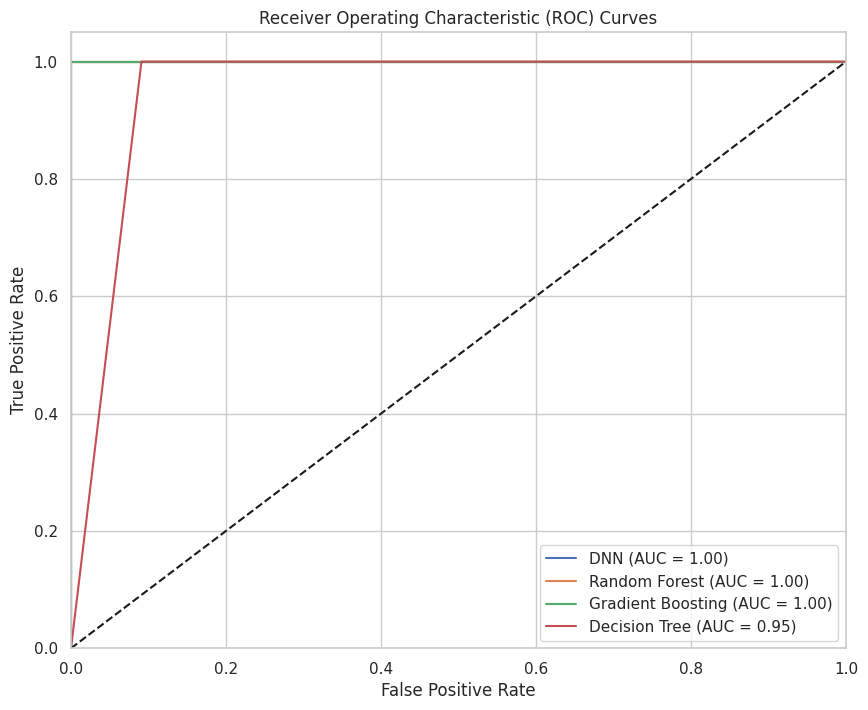

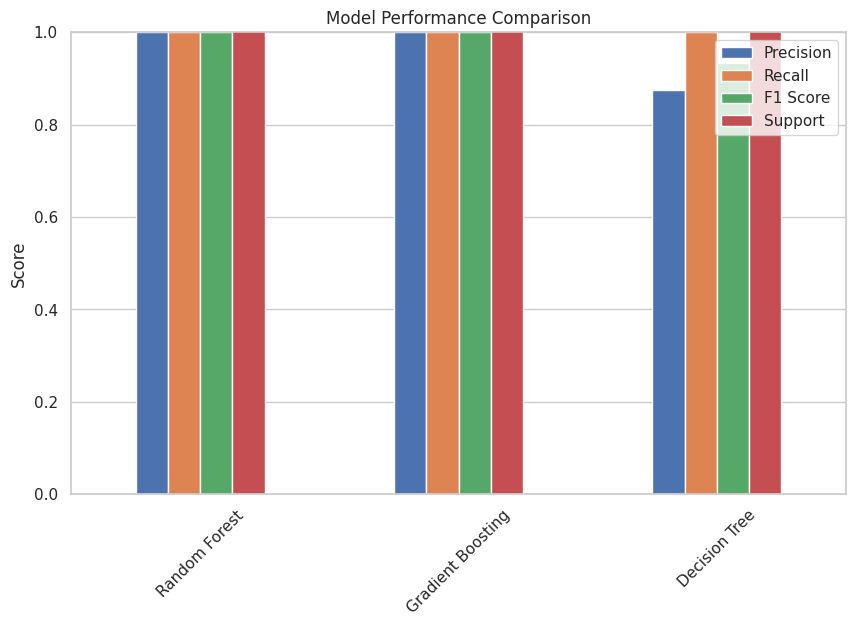

In [54]:
trainEnsamble(df_binaryFeatureFiltered)
